In [1]:
from bs4 import BeautifulSoup
import re, glob
import pandas as pd
from xml.sax import *

In [2]:
sgmls = glob.glob('conll14st-test-data/noalt/*.sgml', recursive=True)
sgmls

['conll14st-test-data/noalt/official-2014.0.sgml',
 'conll14st-test-data/noalt/official-2014.1.sgml']

In [3]:
mistakes = []
for file in sgmls:
    with open(file, 'r') as f:
        soup = BeautifulSoup(f.read(), 'lxml')
        mistakes += [{
            'doc_id': m.find_parent('doc').get('nid'),
            'teacher_id': m.find_parent('annotation').get('teacher_id'),
            'end_off': m.get('end_off'),
            'end_par': m.get('end_par'),
            'start_off': m.get('start_off'),
            'start_par': m.get('start_par'),
            'type': m.type.text, 
            'correction': m.correction.text,
        }
            for m in soup.select('mistake')]
        
mistakes = pd.DataFrame(mistakes)

checks

In [4]:
for file in sgmls:
    with open(file, 'r') as f:
        soup = BeautifulSoup(f.read(), 'lxml')
        for doc in soup.select('doc'):
            if len(doc.select('annotation')) != 1:
                print('no annotations or more than 1 in document')
            if len(doc.select('mistake')) < 1:
                print('no mistakes')

In [5]:
mistakes.head()

,correction,doc_id,end_off,end_par,start_off,start_par,teacher_id,type
0,,1,46,1,42,1,8,ArtOrDet
1,diseases,1,125,1,118,1,8,Nn
2,"However,",1,627,1,620,1,8,Trans
3,diagnosed,1,751,1,740,1,8,Mec
4,,1,754,1,751,1,8,Prep


In [6]:
def merge_unique_mistakes(mistakes, columns=[]):
    t8_mistakes = mistakes.loc[mistakes.teacher_id == '8', ]
    t9_mistakes = mistakes.loc[mistakes.teacher_id == '9', ]

    unique_mistakes = t8_mistakes.reindex(columns=columns + ['teacher_id'],
                                         ).merge(t9_mistakes.reindex(columns=columns + ['teacher_id']),
                                                 on=columns,
                                                 how='outer')

    unique_mistakes.teacher_id_x = unique_mistakes.teacher_id_x.fillna('')
    unique_mistakes.teacher_id_y = unique_mistakes.teacher_id_y.fillna('')
    unique_mistakes['corrected_by_teachers'] = unique_mistakes.teacher_id_x + unique_mistakes.teacher_id_y
    del(unique_mistakes['teacher_id_x'], unique_mistakes['teacher_id_y'])
    
    return unique_mistakes

In [7]:
unique_mistakes = merge_unique_mistakes(mistakes,
                                        ['doc_id', 'end_off', 'end_par', 'start_off', 'start_par', 'type'])
unique_mistakes.corrected_by_teachers.value_counts().plot(kind='bar')

unique_mistakes['corrected_by_teachers'].value_counts()

9     2518
8     1584
89     813
Name: corrected_by_teachers, dtype: int64

**Only ~17% of mistakes were spotted by 2 teachers identically (same span and type).**<br/>
Teacher #9 annotated significantly more mistakes. Is she/he stricter?

In [8]:
from scipy.stats import chi2_contingency
from math import sqrt

In [9]:
chi2, p, dof, expected = chi2_contingency(pd.crosstab(mistakes.type, mistakes.teacher_id))
print(f'''p: {round(p, 5)}\n\
{dof} degrees of freedom\n\
coef: {chi2}\n\
Kramer coef: {sqrt(chi2 / (len(mistakes) * (mistakes.teacher_id.nunique() - 1)))}''')

p: 0.0
26 degrees of freedom
coef: 250.37687471914046
Kramer coef: 0.20907186937533168


There is a correlation between mistake type and teacher

In [10]:
type_teacher = pd.crosstab(mistakes.type, mistakes.teacher_id)
type_teacher['type'] = type_teacher.index
type_teacher.columns.name = None
type_teacher = type_teacher.reset_index(drop=True)
type_teacher['total'] = type_teacher.sum(axis=1)

teacher_per_type = unique_mistakes.groupby(['type', 'corrected_by_teachers'],
                                           as_index=False)['doc_id'].count()
teacher_per_type.columns = ['type', 'corrected_by_teachers', 'count']

type_teacher = type_teacher.merge(teacher_per_type.loc[teacher_per_type.corrected_by_teachers == '89',
                                                      ].reindex(columns=['type', 'count']),
                                  on='type', how='left')
type_teacher.columns = ['8', '9', 'type', 'total', 'mutual']

type_teacher.mutual = type_teacher.mutual / type_teacher.total
type_teacher['diff'] = type_teacher['9'] - type_teacher['8']
type_teacher = type_teacher.sort_values('diff', ascending=False)

In [11]:
type_teacher

,8,9,type,total,mutual,diff
1,231,496,Mec,727,0.119670,265
7,211,390,Prep,601,0.196339,179
24,340,479,Wci,819,0.105006,139
0,332,444,ArtOrDet,776,0.204897,112
8,95,199,Rloc-,294,0.034014,104
6,96,153,Pref,249,0.072289,57
9,105,154,SVA,259,0.220077,49
22,22,54,WOinc,76,0.039474,32
16,12,42,Um,54,NaN,30
25,77,103,Wform,180,0.188889,26


Teacher #9 has greater proportion of punctuation, capitalization, spelling, typos; also of prepositional mistakes, wrong collocations, redundancy<br/> **How much annotators agree on mistakes regardless their type?**

9     2169
8     1235
89    1162
Name: corrected_by_teachers, dtype: int64

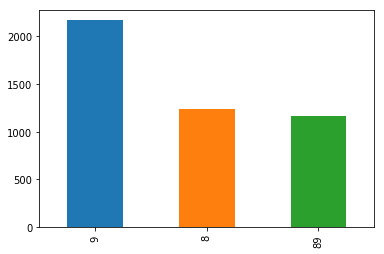

In [12]:
unique_mistakes_notype = merge_unique_mistakes(mistakes,
                                        ['doc_id', 'end_off', 'end_par', 'start_off', 'start_par'])

unique_mistakes_notype.corrected_by_teachers.value_counts().plot(kind='bar')
unique_mistakes_notype['corrected_by_teachers'].value_counts()

**Considering spans in paragraphs only, annotators agree about 25% of mistakes.**